# Implementing a Multi-Layer Perceptron (MLP) in OpenCV

In order to create nonlinear decision boundaries, we can combine multiple perceptrons to
form a larger network. This is also known as a multilayer perceptron (MLP). MLPs usually
consist of at least three layers, where the first layer has a node (or neuron) for every input
feature of the dataset, and the last layer has a node for every class label. The layer in
between is called the hidden layer.

## Loading and preprocessing the data

Implementing an MLP in OpenCV uses the same syntax that we have seen at least a dozen
times before. In order to see how an MLP compares to a single perceptron, we will operate
on the same toy data as before:

In [5]:
from sklearn.datasets.samples_generator import make_blobs
X_raw, y_raw = make_blobs(n_samples=100, centers=2,
                          cluster_std=5.2, random_state=42)

## Preprocessing the data

However, since we are working with OpenCV, this time, we want to make sure the input
matrix is made up of 32-bit floating point numbers, otherwise the code will break:

In [7]:
import numpy as np
X = X_raw.astype(np.float32)

Furthermore, we need to think back to [Chapter 4](04.00-Representing-Data-and-Engineering-Features.ipynb), *Representing Data and Engineering and Features*, and remember how to represent categorical variables. We need to find a way to
represent target labels, not as integers but with a one-hot encoding. The easiest way to
achieve this is by using scikit-learn's `preprocessing` module:

In [8]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(sparse=False, dtype=np.float32,categories='auto')
y = enc.fit_transform(y_raw.reshape(-1, 1))

## Creating an MLP classifier in OpenCV

The syntax to create an MLP in OpenCV is the same as for all the other classifiers:

In [9]:
import cv2
mlp = cv2.ml.ANN_MLP_create()

However, now we need to specify how many layers we want in the network and how many
neurons there are per layer. We do this with a list of integers, which specify the number of
neurons in each layer. Since the data matrix `X` has two features, the first layer should also
have two neurons in it (`n_input`). Since the output has two different values, the last layer
should also have two neurons in it (`n_output`). In between these two layers, we can put as
many hidden layers with as many neurons as we want. Let's choose a single hidden layer
with an arbitrary number of ten neurons in it (`n_hidden`):

In [29]:
n_input = 2
n_hidden = 10
n_output = 2
mlp.setLayerSizes(np.array([n_input, n_hidden, n_output]))

## Customizing the MLP classifier

Before we move on to training the classifier, we can customize the MLP classifier via a
number of optional settings:
- `mlp.setActivationFunction`: This defines the activation function to be used for every neuron in the network
- `mlp.setTrainMethod`: This defines a suitable training method
- `mlp.setTermCriteria`: This sets the termination criteria of the training phase

Whereas our home-brewed perceptron classifier used a linear activation function, OpenCV
provides two additional options:
- `cv2.ml.ANN_MLP_IDENTITY`: This is the linear activation function, $f(x) = x$.
- `cv2.ml.ANN_MLP_SIGMOID_SYM`: This is the symmetrical sigmoid function (also known as hyperbolic tangent), $f(x) = \beta (1 - \exp(-\alpha x)) / (1 + \exp(-\alpha x))$. Whereas $\alpha$ controls the slope of the function, $\beta$ defines the upper and lower bounds of the output.
- `cv2.ml.ANN_GAUSSIAN`: This is the Gaussian function (also known as the bell curve), $f(x) = \beta \exp(-\alpha x^2)$. Whereas $α$ controls the slope of the function, $\beta$ defines the upper bound of the output.

In this example, we will use a proper sigmoid function that squashes the input values into
the range [0, 1]. We do this by choosing $\alpha = 2.5$ and $\beta = 1.0$:

In [30]:
mlp.setActivationFunction(cv2.ml.ANN_MLP_SIGMOID_SYM, 2.5, 1.0)

If you are curious what this activation function looks like, we can take a short excursion
with Matplotlib:

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Text(0, 0.5, 'y')

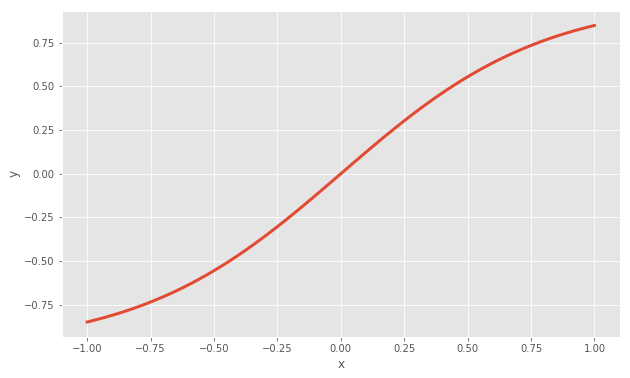

In [32]:
alpha = 2.5
beta = 1.0
x_sig = np.linspace(-1.0, 1.0, 100)
y_sig = beta * (1.0 - np.exp(-alpha * x_sig))
y_sig /= (1 + np.exp(-alpha * x_sig))
plt.figure(figsize=(10, 6))
plt.plot(x_sig, y_sig, linewidth=3)
plt.xlabel('x')
plt.ylabel('y')

As mentioned in the preceding part, a training method can be set via
mlp.setTrainMethod. The following methods are available:
- `cv2.ml.ANN_MLP_BACKPROP`: This is the backpropagation algorithm we talked about previously. You can set additional scaling factors via `mlp.setBackpropMomentumScale` and `mlp.setBackpropWeightScale`.
- `cv2.ml.ANN_MLP_RPROP`: This is the Rprop algorithm, which is short for resilient backpropagation. We won't have time to discuss this algorithm, but you can set additional parameters of this algorithm via `mlp.setRpropDW0`, `mlp.setRpropDWMax`, `mlp.setRpropDWMin`, `mlp.setRpropDWMinus`, and `mlp.setRpropDWPlus`.

In this example, we will choose backpropagation:

In [33]:
mlp.setTrainMethod(cv2.ml.ANN_MLP_BACKPROP)

Lastly, we can specify the criteria that must be met for training to end via
`mlp.setTermCriteria`. This works the same for every classifier in OpenCV and is closely
tied to the underlying C++ functionality. We first tell OpenCV which criteria we are going to
specify (for example, the maximum number of iterations). Then we specify the value for this
criterion. All values must be delivered in a tuple.

In [34]:
term_mode = cv2.TERM_CRITERIA_MAX_ITER + cv2.TERM_CRITERIA_EPS
term_max_iter = 300
term_eps = 0.01
mlp.setTermCriteria((term_mode, term_max_iter, term_eps))

## Training and testing the MLP classifier

This is the easy part. Training the MLP classifier is the same as with all other classifiers:

In [35]:
mlp.train(X, cv2.ml.ROW_SAMPLE, y)

True

The same goes for predicting target labels:

In [36]:
_, y_hat = mlp.predict(X)

The easiest way to measure accuracy is by using scikit-learn's helper function:

In [37]:
from sklearn.metrics import accuracy_score
accuracy_score(y_hat.round(), y)

0.88

It looks like we were able to increase our performance from 81% with a single perceptron to
88% with an MLP consisting of ten hidden-layer neurons and two output neurons. In order
to see what changed, we can look at the decision boundary one more time:

In [38]:
def plot_decision_boundary(classifier, X_test, y_test):
    # create a mesh to plot in
    h = 0.02  # step size in mesh
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    X_hypo = np.c_[xx.ravel().astype(np.float32),
                   yy.ravel().astype(np.float32)]
    _, zz = classifier.predict(X_hypo)
    zz = np.argmax(zz, axis=1)
    zz = zz.reshape(xx.shape)
    
    plt.contourf(xx, yy, zz, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, s=200)

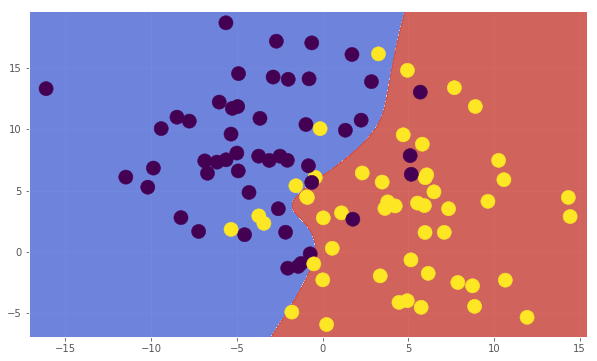

In [39]:
plt.figure(figsize=(10, 6))
plot_decision_boundary(mlp, X, y_raw)

And voila! The decision boundary is no longer a straight line. That being said, you got a great performance increase and might have expected a more drastic performance increase. But nobody said we have to stop here!

There are at least two different things we can try from here on out:
- We can add more neurons to the hidden layer. You can do this by replacing `n_hidden` on line 6 with a larger value and running the code again. Generally speaking, the more neurons you put in the network, the more powerful the MLP will be.
- We can add more hidden layers. It turns out that this is where neural nets really get their power from.

Hence, this is where we should tell you about deep learning.